# MatchMind v4 — Hybrid Scoring with Online Learning

**The Evolution:**
- **v2.1**: Pure Rule-Based (agent predicts exact reward scores)
- **v3.1**: Pure RL (agent learns from simulated +1/-1 feedback)
- **v4**: Hybrid (rule-based safety net + RL predictions + online learning from real feedback)

**Key Innovation:** The model starts by trusting the hand-crafted rules (cold start), then gradually shifts trust to its own learned predictions as real user feedback accumulates.

In [1]:
import pandas as pd
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import KFold
from torch.optim.lr_scheduler import StepLR
from collections import deque
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("updated_data.csv")

## Analyze and Clean Dataset

In [3]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 1211 entries, 0 to 1210
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   user_id                  1200 non-null   float64
 1   name                     1211 non-null   str    
 2   age                      1200 non-null   float64
 3   gender                   1200 non-null   str    
 4   target_gender            1200 non-null   str    
 5   location                 1200 non-null   str    
 6   occupation               1200 non-null   str    
 7   anxiety                  1200 non-null   float64
 8   avoidance                1200 non-null   float64
 9   Lifestyle                1200 non-null   str    
 10  Arts & Creativity        1200 non-null   str    
 11  Music                    1200 non-null   str    
 12  Movies & Shows           1200 non-null   str    
 13  Intellectual & Learning  1200 non-null   str    
 14  Food & Drinks            1200 non-n

In [4]:
df.head()

,user_id,name,age,gender,target_gender,location,occupation,anxiety,avoidance,Lifestyle,Arts & Creativity,Music,Movies & Shows,Intellectual & Learning,Food & Drinks,Sports & Outdoor,Gaming & Digital,Travel & Culture,Personality & Values,Relationship Intent
0,1.0,Nethmi Bandara,37.0,Female,Male,Gampaha,Construction Worker,4.09,6.57,"[""Night Owl"", ""Meditation""]","[""Filmmaking"", ""Graphic Design"", ""Poetry"", ""In...","[""Indie""]","[""Documentaries"", ""Horror"", ""Anime"", ""Sitcoms""]","[""Self-Improvement""]","[""Street Food"", ""Spicy Food"", ""Cooking"", ""Coff...","[""Surfing"", ""Football"", ""Adventure Sports""]","[""Web3"", ""Crypto""]","[""Museums"", ""Beaches"", ""Mountains"", ""Cultural ...","[""Atheist"", ""Feminist""]","[""Open Relationship""]"
1,2.0,Malith,32.0,Male,Female,Kandy,Accountant,3.96,4.88,"[""Traveling"", ""Vegan"", ""Digital Nomad""]","[""Interior Design""]","[""Singing"", ""K-Pop"", ""Rock""]","[""Horror"", ""Documentaries"", ""K-Dramas""]","[""Science"", ""Books & Reading"", ""Self-Improveme...","[""Street Food"", ""Spicy Food"", ""Craft Beer"", ""F...","[""Cricket"", ""Swimming"", ""Hiking"", ""Surfing""]","[""Console Gaming"", ""Board Games"", ""Mobile Gami...","[""Museums"", ""Languages""]","[""Feminist"", ""Family-Oriented"", ""Career-Focuse...","[""Marriage""]"
2,3.0,Isuru,25.0,Male,Female,Gampaha,Accountant,2.63,4.24,"[""Early Bird""]","[""Poetry""]","[""Hip-Hop"", ""EDM""]","[""Sci-Fi""]","[""Technology"", ""History"", ""Science""]","[""Coffee"", ""Cooking"", ""Baking"", ""Street Food""]","[""Surfing"", ""Cycling"", ""Swimming"", ""Football""]","[""Mobile Gaming"", ""Dungeons & Dragons""]","[""Beaches""]","[""Career-Focused"", ""Family-Oriented"", ""Spiritu...","[""Long-Term Relationship""]"
3,4.0,Hashan,25.0,Male,Female,Badulla,Accountant,4.67,1.37,"[""Pet Lover"", ""Meditation"", ""Vegan""]","[""Filmmaking""]","[""Rock"", ""EDM"", ""Singing""]","[""Horror"", ""Sci-Fi""]","[""History"", ""AI & Machine Learning"", ""Technolo...","[""Street Food""]","[""Basketball"", ""Hiking"", ""Surfing"", ""Cycling""]","[""VR"", ""Console Gaming""]","[""Cultural Festivals"", ""Backpacking"", ""Road Tr...","[""Environmentalist"", ""Politically Active""]","[""Open Relationship""]"
4,5.0,Supun,23.0,Male,Female,Kandy,Doctor,3.45,1.17,"[""Traveling"", ""Pet Lover""]","[""Filmmaking"", ""Interior Design"", ""DIY & Crafts""]","[""K-Pop"", ""Pop""]","[""Thriller"", ""Sitcoms"", ""Documentaries""]","[""Self-Improvement"", ""Psychology""]","[""Wine"", ""Baking"", ""Craft Beer""]","[""Hiking"", ""Basketball"", ""Surfing"", ""Camping""]","[""Board Games"", ""Console Gaming"", ""VR""]","[""Luxury Travel"", ""Museums"", ""Road Trips""]","[""Politically Active"", ""Spiritual""]","[""Casual Dating""]"


In [5]:
df.describe()

,user_id,age,anxiety,avoidance
count,1200.000000,1200.000000,1200.000000,1200.000000
mean,600.500000,28.810000,3.470083,3.484917
std,346.554469,6.666403,1.392839,1.363520
min,1.000000,18.000000,1.000000,1.000000
25%,300.750000,23.000000,2.507500,2.497500
50%,600.500000,29.000000,3.380000,3.485000
75%,900.250000,35.000000,4.410000,4.410000
max,1200.000000,40.000000,7.000000,7.000000


In [6]:
df.isnull().sum()

user_id                    11
name                        0
age                        11
gender                     11
target_gender              11
location                   11
occupation                 11
anxiety                    11
avoidance                  11
Lifestyle                  11
Arts & Creativity          11
Music                      11
Movies & Shows             11
Intellectual & Learning    11
Food & Drinks              11
Sports & Outdoor           11
Gaming & Digital           11
Travel & Culture           11
Personality & Values       11
Relationship Intent        11
dtype: int64

In [7]:
df = df.dropna()
df.isnull().sum()
df.drop(columns=['name'], inplace=True)

In [8]:
df.tail()

,user_id,age,gender,target_gender,location,occupation,anxiety,avoidance,Lifestyle,Arts & Creativity,Music,Movies & Shows,Intellectual & Learning,Food & Drinks,Sports & Outdoor,Gaming & Digital,Travel & Culture,Personality & Values,Relationship Intent
1195,1196.0,39.0,Male,Female,Colombo,Driver,2.37,1.84,"[""Vegan"", ""Night Owl""]","[""Writing"", ""Painting"", ""Filmmaking"", ""Interio...","[""Classical"", ""EDM"", ""Rock"", ""Pop""]","[""Horror"", ""Anime"", ""Documentaries""]","[""Psychology""]","[""Fine Dining"", ""Baking""]","[""Hiking"", ""Camping""]","[""Web3""]","[""Backpacking"", ""Cultural Festivals"", ""Road Tr...","[""Family-Oriented"", ""Spiritual"", ""Feminist"", ""...","[""Marriage""]"
1196,1197.0,27.0,Male,Female,Colombo,Doctor,1.73,4.23,"[""Vegetarian"", ""Night Owl""]","[""Interior Design"", ""Graphic Design"", ""Poetry""...","[""Playing Instruments""]","[""Romance"", ""Documentaries"", ""Sci-Fi""]","[""Psychology"", ""Books & Reading"", ""AI & Machin...","[""Street Food"", ""Baking""]","[""Cycling""]","[""Console Gaming"", ""Crypto""]","[""Languages"", ""Mountains"", ""Beaches""]","[""Atheist"", ""Spiritual"", ""Family-Oriented"", ""C...","[""Casual Dating""]"
1197,1198.0,33.0,Male,Female,Ratnapura,Doctor,4.29,2.50,"[""Early Bird"", ""Pet Lover""]","[""Poetry"", ""Painting""]","[""Singing""]","[""Sitcoms"", ""K-Dramas"", ""Romance"", ""Thriller""]","[""Philosophy""]","[""Spicy Food"", ""Cooking"", ""Fine Dining"", ""Baki...","[""Cricket"", ""Football"", ""Camping"", ""Basketball""]","[""Dungeons & Dragons"", ""eSports"", ""Board Games...","[""Mountains""]","[""Religious"", ""Family-Oriented"", ""Career-Focus...","[""Marriage""]"
1198,1199.0,32.0,Female,Male,Badulla,Business Owner,3.53,3.58,"[""Vegan"", ""Gym"", ""Vegetarian"", ""Fitness""]","[""Graphic Design"", ""Interior Design""]","[""EDM"", ""Hip-Hop"", ""Jazz""]","[""K-Dramas""]","[""Books & Reading""]","[""Fine Dining"", ""Street Food""]","[""Cricket""]","[""Mobile Gaming"", ""Board Games"", ""eSports""]","[""Museums"", ""Languages"", ""Road Trips""]","[""Family-Oriented"", ""Spiritual"", ""Career-Focus...","[""Long-Term Relationship""]"
1199,1200.0,28.0,Female,Male,Monaragala,Farmer,6.05,6.33,"[""Fitness"", ""Night Owl""]","[""Fashion""]","[""EDM"", ""Pop"", ""Playing Instruments"", ""Hip-Hop""]","[""Thriller"", ""Anime"", ""K-Dramas"", ""Documentari...","[""Self-Improvement""]","[""Baking"", ""Cooking""]","[""Adventure Sports"", ""Swimming"", ""Basketball""]","[""Dungeons & Dragons""]","[""Museums"", ""Beaches"", ""Mountains""]","[""Atheist"", ""Politically Active""]","[""Still Figuring It Out""]"


### Data Preprocessing and Reward System

In [9]:
# ================================================================
# CATEGORY WEIGHTS — The Rule-Based Backbone
# ================================================================
# These weights represent our domain expertise about what matters
# in a relationship. They serve TWO purposes in v4:
#   1. Training: Shape the simulated environment rewards
#   2. Deployment: Act as a safety net score alongside the RL model
# ================================================================

CATEGORY_WEIGHTS = {
    "Relationship Intent": 40.0,   # Dealbreaker
    "Personality & Values": 20.0,  # High impact on stability
    "Lifestyle": 15.0,             # Day-to-day friction
    "Intellectual & Learning": 5.0,
    "Food & Drinks": 5.0,
    "Travel & Culture": 5.0,
    "Gaming & Digital": 5.0,
    "Sports & Outdoor": 5.0,
    "Arts & Creativity": 3.0,
    "Music": 2.0,
    "Movies & Shows": 2.0
}
# Total max category points = 107.0


def calculate_jaccard(list_a, list_b):
    """Calculates the percentage overlap between two lists (0.0 to 1.0)"""
    set_a, set_b = set(list_a), set(list_b)
    intersection = len(set_a.intersection(set_b))
    union = len(set_a.union(set_b))
    if union == 0:
        return 0.0
    return intersection / union


def process_pair(user_a, user_b):
    """
    Takes two raw user rows and returns:
    1. The State Vector (16 features for the Neural Network)
    2. The Rule-Based Reward (weighted score from domain expertise)
    """

    # 1. Hard Constraints (Dealbreakers)
    if user_a['target_gender'] != user_b['gender'] or user_b['target_gender'] != user_a['gender']:
        return None, -100.0

    if user_a['location'] != user_b['location']:
        return None, -50.0

    # 2. Calculate 11 Category Overlaps
    category_overlaps = {}
    reward_from_interests = 0.0

    for cat, weight in CATEGORY_WEIGHTS.items():
        items_a = json.loads(user_a[cat])
        items_b = json.loads(user_b[cat])
        overlap = calculate_jaccard(items_a, items_b)
        category_overlaps[cat] = overlap
        reward_from_interests += (overlap * weight)

    # 3. Psychology Reward
    trap_metric = (user_a['anxiety'] * user_b['avoidance']) + (user_b['anxiety'] * user_a['avoidance'])

    psych_reward = 50.0
    if trap_metric > 35: psych_reward -= 40.0  # Anxious-Avoidant trap penalty
    if user_a['anxiety'] < 3.0 and user_b['anxiety'] < 3.0: psych_reward += 20.0  # Secure bonus

    total_reward = reward_from_interests + psych_reward

    # 4. Build State Vector (16 features)
    state_vector = [
        abs(user_a['age'] - user_b['age']) / 10.0,
        user_a['anxiety'] / 7.0,
        user_a['avoidance'] / 7.0,
        user_b['anxiety'] / 7.0,
        user_b['avoidance'] / 7.0,
    ]

    for cat in CATEGORY_WEIGHTS.keys():
        state_vector.append(category_overlaps[cat])

    return np.array(state_vector), total_reward


def simulate_user_interaction(user_a, candidate_b):
    """
    The HIDDEN Environment Simulator.
    Converts the rule-based score into a stochastic Confirm/Skip decision.
    """
    state_vector, hidden_score = process_pair(user_a, candidate_b)

    if state_vector is None:
        return None, -1.0

    confirm_probability = np.clip(hidden_score / 120.0, 0.05, 0.95)

    if random.random() <= confirm_probability:
        return state_vector, 1.0   # CONFIRM
    else:
        return state_vector, -1.0  # SKIP


# --- Test ---
print("Testing the Confirm/Skip Simulator...")
state, simulated_reward = simulate_user_interaction(df.iloc[0], df.iloc[1])
print(f"Result: {'CONFIRM (+1)' if simulated_reward == 1.0 else 'SKIP (-1)'}")

Testing the Confirm/Skip Simulator...
Result: SKIP (-1)


### Device Setup

In [10]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


## Phase 1: Pre-Train the RL Agent (Same as v3.1)

Before deploying, we pre-train using the simulated environment so the agent isn't completely blind on day 1.

In [11]:
# --- NEURAL NETWORK (Same architecture as v3.1) ---
class MatchmakerDQN(nn.Module):
    def __init__(self):
        super(MatchmakerDQN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(16, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.network(x)


# Initialize Agent
agent = MatchmakerDQN().to(device)
optimizer = optim.Adam(agent.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=1500, gamma=0.5)
criterion = nn.MSELoss()

# Experience Replay Buffer
memory = deque(maxlen=10000)
BATCH_SIZE = 64

# Hyperparameters
EPOCHS = 5000
epsilon = 1.0
epsilon_decay = 0.999
epsilon_min = 0.05

print(f"Phase 1: Pre-Training DQN for {EPOCHS} Epochs (Simulated Environment)...")

agent.train()
reward_tracking = []

for epoch in range(EPOCHS):
    target_idx = random.randint(0, len(df) - 1)
    target_user = df.iloc[target_idx]

    candidates = df[
        (df['user_id'] != target_user['user_id']) &
        (df['gender'] == target_user['target_gender']) &
        (df['target_gender'] == target_user['gender']) &
        (df['location'] == target_user['location'])
    ]
    if len(candidates) == 0: continue

    feed_candidates = candidates.sample(min(10, len(candidates)))
    feed_states, valid_cands = [], []

    for _, cand in feed_candidates.iterrows():
        state, _ = process_pair(target_user, cand)
        if state is not None:
            feed_states.append(state)
            valid_cands.append(cand)

    if not feed_states: continue
    state_tensors = torch.FloatTensor(np.array(feed_states)).to(device)

    # Epsilon-Greedy Action
    if random.random() < epsilon:
        chosen_idx = random.randint(0, len(feed_states) - 1)
    else:
        with torch.no_grad():
            q_values = agent(state_tensors)
            chosen_idx = torch.argmax(q_values).item()

    chosen_candidate = valid_cands[chosen_idx]

    # Environment Interaction
    _, actual_reward = simulate_user_interaction(target_user, chosen_candidate)
    reward_tracking.append(actual_reward)

    # Save to Replay Buffer
    memory.append((feed_states[chosen_idx], actual_reward))

    # Batch Learning
    if len(memory) >= BATCH_SIZE:
        minibatch = random.sample(memory, BATCH_SIZE)
        batch_states = torch.FloatTensor(np.array([m[0] for m in minibatch])).to(device)
        batch_rewards = torch.FloatTensor([[m[1]] for m in minibatch]).to(device)

        optimizer.zero_grad()
        predicted_q_values = agent(batch_states)
        loss = criterion(predicted_q_values, batch_rewards)
        loss.backward()
        optimizer.step()

    scheduler.step()
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay

    if (epoch + 1) % 500 == 0:
        recent_win_rate = (sum(reward_tracking[-500:]) / 500)
        print(f"Epoch [{epoch+1}/{EPOCHS}] | Epsilon: {epsilon:.2f} | LR: {scheduler.get_last_lr()[0]:.5f} | Recent Reward Avg: {recent_win_rate:.2f}")

print("\nPhase 1 Complete! Pre-trained agent ready.")

Phase 1: Pre-Training DQN for 5000 Epochs (Simulated Environment)...
Epoch [500/5000] | Epsilon: 0.61 | LR: 0.00100 | Recent Reward Avg: 0.20
Epoch [1000/5000] | Epsilon: 0.37 | LR: 0.00100 | Recent Reward Avg: 0.36
Epoch [1500/5000] | Epsilon: 0.22 | LR: 0.00050 | Recent Reward Avg: 0.39
Epoch [2000/5000] | Epsilon: 0.14 | LR: 0.00050 | Recent Reward Avg: 0.47
Epoch [2500/5000] | Epsilon: 0.08 | LR: 0.00050 | Recent Reward Avg: 0.50
Epoch [3000/5000] | Epsilon: 0.05 | LR: 0.00025 | Recent Reward Avg: 0.51
Epoch [3500/5000] | Epsilon: 0.05 | LR: 0.00025 | Recent Reward Avg: 0.50
Epoch [4000/5000] | Epsilon: 0.05 | LR: 0.00025 | Recent Reward Avg: 0.49
Epoch [4500/5000] | Epsilon: 0.05 | LR: 0.00013 | Recent Reward Avg: 0.56
Epoch [5000/5000] | Epsilon: 0.05 | LR: 0.00013 | Recent Reward Avg: 0.57

Phase 1 Complete! Pre-trained agent ready.


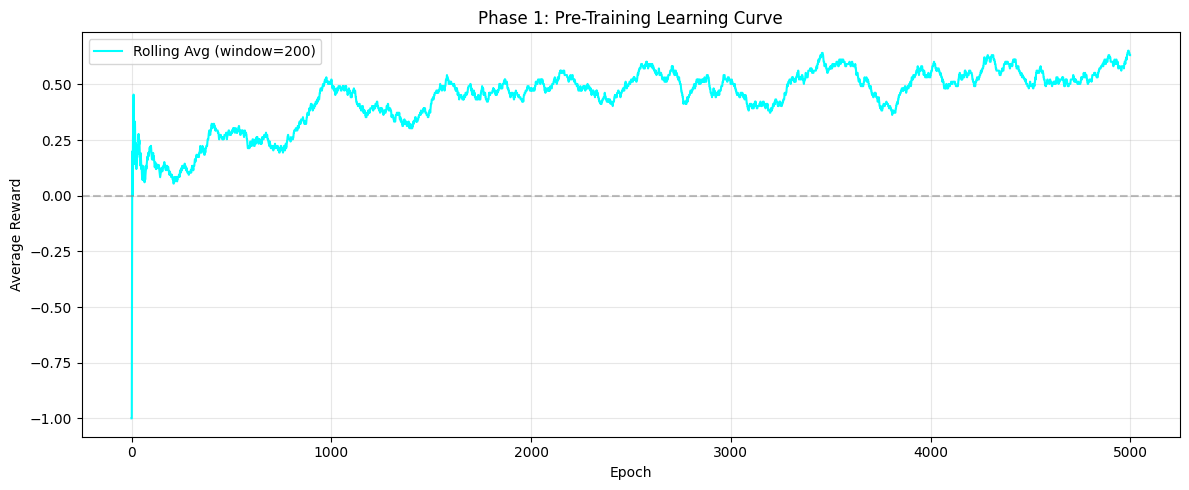

In [12]:
# --- Pre-Training Reward Curve ---
window = 200
rolling_avg = [
    np.mean(reward_tracking[max(0, i - window):i + 1])
    for i in range(len(reward_tracking))
]

plt.figure(figsize=(12, 5))
plt.plot(rolling_avg, color='cyan', linewidth=1.5, label=f'Rolling Avg (window={window})')
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
plt.xlabel('Epoch')
plt.ylabel('Average Reward')
plt.title('Phase 1: Pre-Training Learning Curve')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Phase 2: The Hybrid Scoring Engine

This is the core v4 innovation. Instead of relying purely on the RL model (which may have learned imperfectly) or purely on rules (which can't adapt), we **blend both**:

$$\text{Final Score} = \alpha \times \text{RL\_Score} + (1 - \alpha) \times \text{Rule\_Score}$$

Where:
- $\alpha$ starts low (trust rules more) and increases as the model collects real feedback
- Rule Score = normalized weighted reward from `process_pair()`
- RL Score = the neural network's Q-value prediction

In [13]:
# ================================================================
# THE HYBRID SCORING ENGINE
# ================================================================

class HybridMatchmaker:
    """
    Combines Rule-Based scoring (v2.1) with RL predictions (v3.1)
    and learns online from real user feedback.
    
    Alpha (α) controls the blend:
    - α = 0.0 → 100% rules (cold start / no real feedback yet)
    - α = 1.0 → 100% RL model (fully trained on real data)
    """
    
    def __init__(self, rl_agent, device, initial_alpha=0.3):
        self.rl_agent = rl_agent
        self.device = device
        self.alpha = initial_alpha  # Starting blend ratio
        
        # Online learning components
        self.online_memory = deque(maxlen=5000)  # Real user feedback buffer
        self.online_optimizer = optim.Adam(rl_agent.parameters(), lr=0.0005)  # Lower LR for fine-tuning
        self.online_criterion = nn.MSELoss()
        self.online_batch_size = 32
        
        # Tracking
        self.total_feedback_count = 0
        self.alpha_history = [initial_alpha]
        self.online_reward_history = []
        
        # Alpha scheduler thresholds
        # As we collect more real feedback, trust the model more
        self.alpha_schedule = [
            (0,    0.3),   # 0 feedbacks:    30% RL, 70% rules
            (50,   0.4),   # 50 feedbacks:   40% RL, 60% rules
            (200,  0.5),   # 200 feedbacks:  50/50 blend
            (500,  0.65),  # 500 feedbacks:  65% RL, 35% rules
            (1000, 0.75),  # 1000 feedbacks: 75% RL, 25% rules
            (2000, 0.85),  # 2000 feedbacks: 85% RL, 15% rules
            (5000, 0.90),  # 5000 feedbacks: 90% RL, 10% rules (rules are always a safety net)
        ]
    
    def _update_alpha(self):
        """Shift trust from rules → model based on accumulated real feedback."""
        for threshold, alpha_value in reversed(self.alpha_schedule):
            if self.total_feedback_count >= threshold:
                self.alpha = alpha_value
                break
        self.alpha_history.append(self.alpha)
    
    def get_rule_score(self, user_a, user_b):
        """
        The v2.1 approach: Calculate the raw weighted reward and normalize to [-1, 1].
        This is always available, requires no training data.
        """
        state_vector, raw_reward = process_pair(user_a, user_b)
        if state_vector is None:
            return None, None
        
        # Normalize the rule score to roughly [-1, 1] range
        # Max possible reward ≈ 107 (interests) + 70 (psych) = 177
        # Min possible reward ≈ 0 (interests) + 10 (psych) = 10
        # We use 120 as the normalization factor (a "great" score)
        normalized_rule_score = np.clip(raw_reward / 120.0, -1.0, 1.0)
        
        return state_vector, normalized_rule_score
    
    def get_rl_score(self, state_vector):
        """The v3.1 approach: Neural network prediction from the state vector."""
        self.rl_agent.eval()
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state_vector).to(self.device)
            rl_score = self.rl_agent(state_tensor).item()
        return rl_score
    
    def get_hybrid_score(self, user_a, user_b):
        """
        THE v4 CORE: Blend RL prediction with rule-based score.
        
        Returns: (state_vector, hybrid_score, rl_score, rule_score) or (None, None, None, None)
        """
        state_vector, rule_score = self.get_rule_score(user_a, user_b)
        
        if state_vector is None:
            return None, None, None, None
        
        rl_score = self.get_rl_score(state_vector)
        
        # THE HYBRID FORMULA
        hybrid_score = (self.alpha * rl_score) + ((1 - self.alpha) * rule_score)
        
        return state_vector, hybrid_score, rl_score, rule_score
    
    def record_feedback(self, state_vector, user_action):
        """
        Record REAL user feedback and use it to improve the model.
        
        Args:
            state_vector: The 16-feature state of the pair
            user_action: +1.0 (Confirm) or -1.0 (Skip) — REAL user action
        """
        self.total_feedback_count += 1
        self.online_reward_history.append(user_action)
        
        # Store in online memory
        self.online_memory.append((state_vector, user_action))
        
        # Online learning: fine-tune from real feedback
        if len(self.online_memory) >= self.online_batch_size:
            self._online_learn()
        
        # Update alpha based on new feedback count
        self._update_alpha()
    
    def _online_learn(self):
        """Fine-tune the RL model using a batch of real user feedback."""
        self.rl_agent.train()
        
        minibatch = random.sample(self.online_memory, self.online_batch_size)
        batch_states = torch.FloatTensor(np.array([m[0] for m in minibatch])).to(self.device)
        batch_rewards = torch.FloatTensor([[m[1]] for m in minibatch]).to(self.device)
        
        self.online_optimizer.zero_grad()
        predicted_q = self.rl_agent(batch_states)
        loss = self.online_criterion(predicted_q, batch_rewards)
        loss.backward()
        self.online_optimizer.step()
    
    def find_matches(self, target_user_id, environment_df, top_n=5):
        """
        The DEPLOYMENT function: Find best matches using hybrid scoring.
        """
        self.rl_agent.eval()
        target_user = environment_df[environment_df['user_id'] == target_user_id].iloc[0]
        
        # Stage 1: Hard Filters
        candidates = environment_df[
            (environment_df['user_id'] != target_user_id) &
            (environment_df['gender'] == target_user['target_gender']) &
            (environment_df['target_gender'] == target_user['gender']) &
            (environment_df['location'] == target_user['location'])
        ]
        
        print(f"Candidates after hard filters: {len(candidates)}")
        print(f"Current Alpha: {self.alpha:.2f} (RL: {self.alpha*100:.0f}% | Rules: {(1-self.alpha)*100:.0f}%)")
        print(f"Real feedback collected: {self.total_feedback_count}")
        
        match_predictions = []
        
        # Stage 2: Hybrid Scoring
        with torch.no_grad():
            for _, candidate in candidates.iterrows():
                state_vector, hybrid_score, rl_score, rule_score = self.get_hybrid_score(target_user, candidate)
                
                if state_vector is not None:
                    match_predictions.append({
                        'candidate_id': candidate['user_id'],
                        'occupation': candidate['occupation'],
                        'anxiety': candidate['anxiety'],
                        'avoidance': candidate['avoidance'],
                        'hybrid_score': hybrid_score,
                        'rl_score': rl_score,
                        'rule_score': rule_score,
                        'state_vector': state_vector  # Stored for feedback recording
                    })
        
        match_predictions.sort(key=lambda x: x['hybrid_score'], reverse=True)
        return match_predictions[:top_n]


# --- Initialize the Hybrid Matchmaker ---
hybrid = HybridMatchmaker(rl_agent=agent, device=device, initial_alpha=0.3)
print(f"Hybrid Matchmaker initialized!")
print(f"Starting Alpha: {hybrid.alpha} (30% RL, 70% Rules)")

Hybrid Matchmaker initialized!
Starting Alpha: 0.3 (30% RL, 70% Rules)


## Phase 3: Simulated Deployment with Online Learning

We simulate what happens when real users start using the app:
1. The system recommends matches using **hybrid scoring**
2. The user confirms or skips (simulated here, but in production this is REAL)
3. The feedback is recorded and the model **learns online**
4. Alpha gradually shifts trust toward the RL model

In [14]:
# ================================================================
# SIMULATED REAL-WORLD DEPLOYMENT
# ================================================================
# This simulates 2000 real user sessions where:
# - The hybrid system recommends a match
# - The user gives feedback (confirm/skip)
# - The model learns from that feedback in real-time
# ================================================================

DEPLOYMENT_SESSIONS = 2000

# Track performance at different stages
hybrid_confirms = []
pure_rl_confirms = []
pure_rule_confirms = []
alpha_over_time = []

print(f"Simulating {DEPLOYMENT_SESSIONS} real user sessions with online learning...\n")

for session in range(DEPLOYMENT_SESSIONS):
    # Random user opens the app
    target_idx = random.randint(0, len(df) - 1)
    target_user = df.iloc[target_idx]
    
    # Find viable candidates
    candidates = df[
        (df['user_id'] != target_user['user_id']) &
        (df['gender'] == target_user['target_gender']) &
        (df['target_gender'] == target_user['gender']) &
        (df['location'] == target_user['location'])
    ]
    
    if len(candidates) == 0: continue
    
    # Score ALL candidates with all 3 strategies
    hybrid_scores = []
    rl_scores = []
    rule_scores = []
    valid_cands = []
    state_vectors = []
    
    for _, cand in candidates.iterrows():
        sv, h_score, r_score, rule_s = hybrid.get_hybrid_score(target_user, cand)
        if sv is not None:
            hybrid_scores.append(h_score)
            rl_scores.append(r_score)
            rule_scores.append(rule_s)
            valid_cands.append(cand)
            state_vectors.append(sv)
    
    if not valid_cands: continue
    
    # Each strategy picks its best candidate
    hybrid_pick = np.argmax(hybrid_scores)
    rl_pick = np.argmax(rl_scores)
    rule_pick = np.argmax(rule_scores)
    
    # Simulate the REAL user response for each strategy's pick
    _, hybrid_reward = simulate_user_interaction(target_user, valid_cands[hybrid_pick])
    _, rl_reward = simulate_user_interaction(target_user, valid_cands[rl_pick])
    _, rule_reward = simulate_user_interaction(target_user, valid_cands[rule_pick])
    
    hybrid_confirms.append(1 if hybrid_reward == 1.0 else 0)
    pure_rl_confirms.append(1 if rl_reward == 1.0 else 0)
    pure_rule_confirms.append(1 if rule_reward == 1.0 else 0)
    
    # THE KEY: Record real feedback and learn from it
    # In production, hybrid_reward would be the ACTUAL user's confirm/skip
    hybrid.record_feedback(state_vectors[hybrid_pick], hybrid_reward)
    
    alpha_over_time.append(hybrid.alpha)
    
    # Progress report
    if (session + 1) % 500 == 0:
        recent = 200
        h_rate = np.mean(hybrid_confirms[-recent:]) * 100
        r_rate = np.mean(pure_rl_confirms[-recent:]) * 100
        rule_rate = np.mean(pure_rule_confirms[-recent:]) * 100
        print(f"Session {session+1}/{DEPLOYMENT_SESSIONS} | Alpha: {hybrid.alpha:.2f} | "
              f"Hybrid: {h_rate:.1f}% | RL: {r_rate:.1f}% | Rules: {rule_rate:.1f}%")

print(f"\nOnline Learning Complete! Total real feedback: {hybrid.total_feedback_count}")

Simulating 2000 real user sessions with online learning...

Session 500/2000 | Alpha: 0.65 | Hybrid: 87.0% | RL: 68.0% | Rules: 92.5%
Session 1000/2000 | Alpha: 0.75 | Hybrid: 90.5% | RL: 82.5% | Rules: 93.5%
Session 1500/2000 | Alpha: 0.75 | Hybrid: 90.5% | RL: 88.0% | Rules: 93.5%
Session 2000/2000 | Alpha: 0.85 | Hybrid: 86.5% | RL: 83.0% | Rules: 92.0%

Online Learning Complete! Total real feedback: 2000


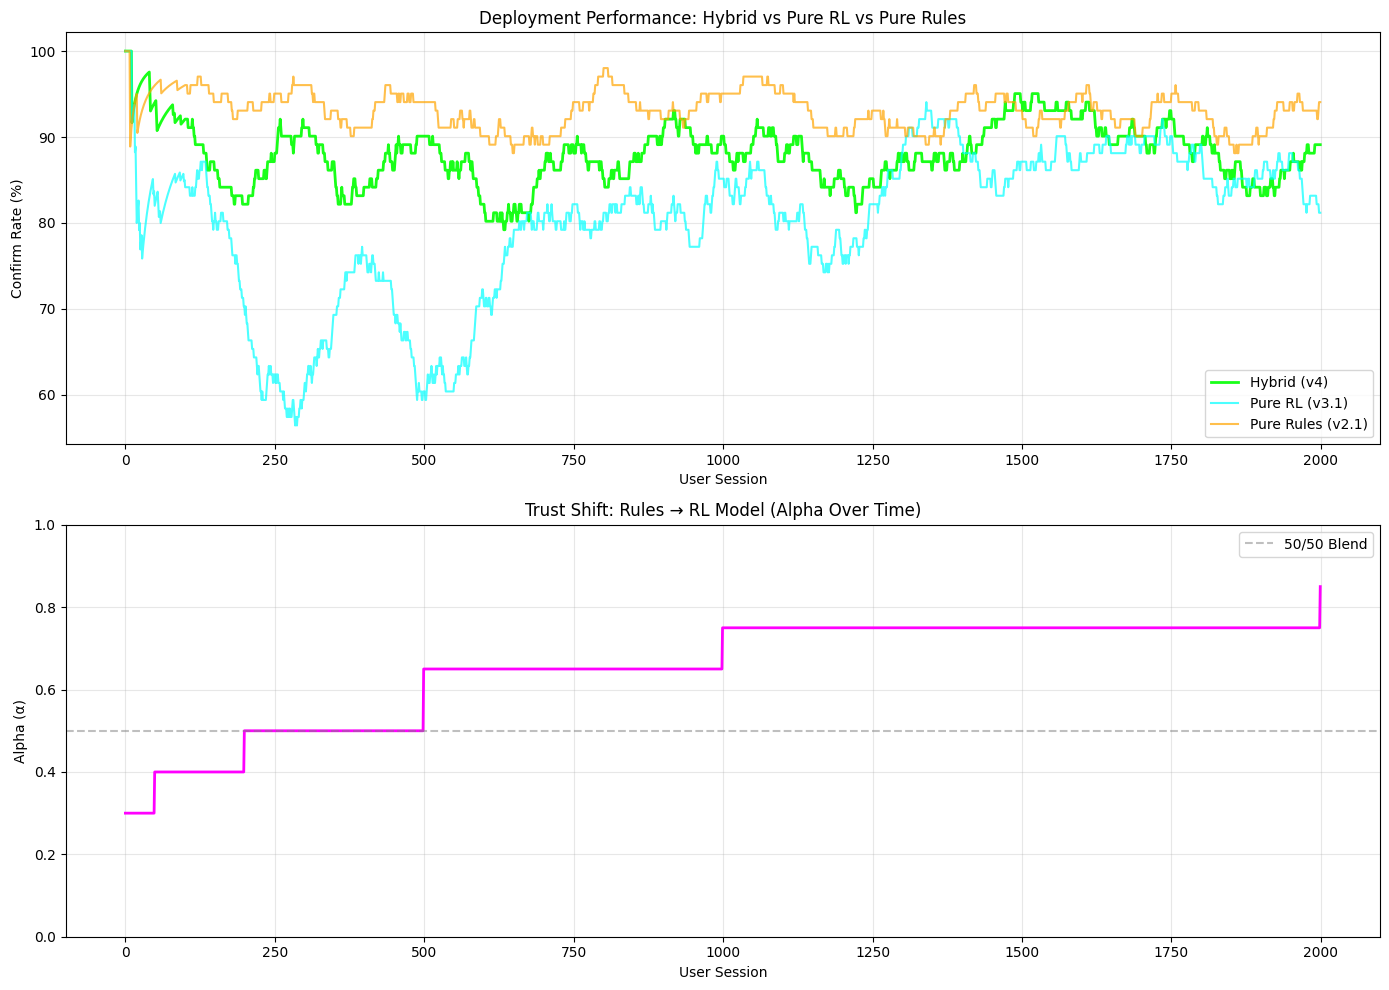


DEPLOYMENT SIMULATION RESULTS
Total Sessions: 2000
Final Alpha:    0.85 (85% RL / 15% Rules)
-------------------------------------------------------
Hybrid (v4):    87.9% Overall Confirm Rate
Pure RL (v3.1): 80.0% Overall Confirm Rate
Pure Rules:     93.0% Overall Confirm Rate


In [15]:
# ================================================================
# DEPLOYMENT PERFORMANCE VISUALIZATION
# ================================================================

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# --- Plot 1: Confirm Rate Comparison Over Time ---
window = 100

def rolling_mean(data, w):
    return [np.mean(data[max(0, i-w):i+1]) * 100 for i in range(len(data))]

axes[0].plot(rolling_mean(hybrid_confirms, window), color='lime', linewidth=2, label='Hybrid (v4)', alpha=0.9)
axes[0].plot(rolling_mean(pure_rl_confirms, window), color='cyan', linewidth=1.5, label='Pure RL (v3.1)', alpha=0.7)
axes[0].plot(rolling_mean(pure_rule_confirms, window), color='orange', linewidth=1.5, label='Pure Rules (v2.1)', alpha=0.7)
axes[0].set_xlabel('User Session')
axes[0].set_ylabel('Confirm Rate (%)')
axes[0].set_title('Deployment Performance: Hybrid vs Pure RL vs Pure Rules')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# --- Plot 2: Alpha Transition Over Time ---
axes[1].plot(alpha_over_time, color='magenta', linewidth=2)
axes[1].set_xlabel('User Session')
axes[1].set_ylabel('Alpha (α)')
axes[1].set_title('Trust Shift: Rules → RL Model (Alpha Over Time)')
axes[1].set_ylim(0, 1)
axes[1].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='50/50 Blend')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print Summary
print("\n" + "=" * 55)
print("DEPLOYMENT SIMULATION RESULTS")
print("=" * 55)
print(f"Total Sessions: {len(hybrid_confirms)}")
print(f"Final Alpha:    {hybrid.alpha:.2f} ({hybrid.alpha*100:.0f}% RL / {(1-hybrid.alpha)*100:.0f}% Rules)")
print("-" * 55)
print(f"Hybrid (v4):    {np.mean(hybrid_confirms)*100:.1f}% Overall Confirm Rate")
print(f"Pure RL (v3.1): {np.mean(pure_rl_confirms)*100:.1f}% Overall Confirm Rate")
print(f"Pure Rules:     {np.mean(pure_rule_confirms)*100:.1f}% Overall Confirm Rate")
print("=" * 55)

## Phase 4: Evaluation — Comparing All Approaches

In [16]:
def evaluate_all_strategies(environment_df, hybrid_matchmaker, num_trials=500):
    """
    Final evaluation comparing 4 strategies:
    1. Hybrid (v4) — blended scoring with online-learned model
    2. Pure RL (v3.1) — RL model only
    3. Pure Rules (v2.1) — weighted reward only
    4. Random — baseline
    """
    print(f"Running Final Evaluation over {num_trials} trials...\n")
    
    hybrid_matchmaker.rl_agent.eval()
    
    results = {'hybrid': 0, 'rl': 0, 'rules': 0, 'random': 0}
    valid_trials = 0
    
    with torch.no_grad():
        for _ in range(num_trials):
            target_idx = random.randint(0, len(environment_df) - 1)
            target_user = environment_df.iloc[target_idx]
            
            candidates = environment_df[
                (environment_df['user_id'] != target_user['user_id']) &
                (environment_df['gender'] == target_user['target_gender']) &
                (environment_df['target_gender'] == target_user['gender']) &
                (environment_df['location'] == target_user['location'])
            ]
            
            if len(candidates) == 0: continue
            valid_trials += 1
            
            h_scores, rl_scores, rule_scores = [], [], []
            valid_cands = []
            
            for _, cand in candidates.iterrows():
                sv, h_s, r_s, ru_s = hybrid_matchmaker.get_hybrid_score(target_user, cand)
                if sv is not None:
                    h_scores.append(h_s)
                    rl_scores.append(r_s)
                    rule_scores.append(ru_s)
                    valid_cands.append(cand)
            
            if not valid_cands: continue
            
            # Each strategy picks its #1
            picks = {
                'hybrid': valid_cands[np.argmax(h_scores)],
                'rl': valid_cands[np.argmax(rl_scores)],
                'rules': valid_cands[np.argmax(rule_scores)],
                'random': valid_cands[random.randint(0, len(valid_cands) - 1)],
            }
            
            for strategy, pick in picks.items():
                _, reward = simulate_user_interaction(target_user, pick)
                if reward == 1.0:
                    results[strategy] += 1
    
    print("-" * 55)
    print("FINAL EVALUATION — Confirm Rate Comparison")
    print("-" * 55)
    for strategy, confirms in results.items():
        rate = (confirms / valid_trials) * 100
        label = {'hybrid': 'Hybrid (v4)', 'rl': 'Pure RL (v3.1)', 'rules': 'Pure Rules (v2.1)', 'random': 'Random Baseline'}[strategy]
        bar = '█' * int(rate / 2)
        print(f"{label:<20} {rate:>5.1f}%  {bar}")
    print("-" * 55)
    print(f"Alpha at evaluation: {hybrid_matchmaker.alpha:.2f}")
    print(f"Total real feedback: {hybrid_matchmaker.total_feedback_count}")


evaluate_all_strategies(df, hybrid, num_trials=500)

Running Final Evaluation over 500 trials...

-------------------------------------------------------
FINAL EVALUATION — Confirm Rate Comparison
-------------------------------------------------------
Hybrid (v4)           85.4%  ██████████████████████████████████████████
Pure RL (v3.1)        84.4%  ██████████████████████████████████████████
Pure Rules (v2.1)     92.0%  ██████████████████████████████████████████████
Random Baseline       55.4%  ███████████████████████████
-------------------------------------------------------
Alpha at evaluation: 0.85
Total real feedback: 2000


## Test with a New User

In [17]:
# 1. Remove existing test user
df = df[df['user_id'] != 9999]

# 2. Create test user
test_user = {
    'user_id': 9999,
    'age': 23,
    'gender': 'Male',
    'target_gender': 'Female',
    'location': 'Galle',
    'occupation': 'Software Engineer',
    'anxiety': 1.5,
    'avoidance': 1.2,
    'Relationship Intent': json.dumps(['Long-Term Relationship']),
    'Gaming & Digital': json.dumps(['PC Gaming', 'Game Dev']),
    'Intellectual & Learning': json.dumps(['Technology', 'Science']),
    'Personality & Values': json.dumps(['Logic-Driven', 'Honesty']),
    'Lifestyle': json.dumps(['Night Owl', 'Digital Nomad']),
    'Music': json.dumps(['EDM', 'Indie']),
    'Movies & Shows': json.dumps(['Sci-Fi']),
    'Food & Drinks': json.dumps(['Coffee Enthusiast']),
    'Sports & Outdoor': json.dumps(['Gym']),
    'Travel & Culture': json.dumps(['Backpacking']),
    'Arts & Creativity': json.dumps(['Creative Writing'])
}

# 3. Inject
df = pd.concat([df, pd.DataFrame([test_user])], ignore_index=True)

# 4. Find matches using HYBRID scoring
top_matches = hybrid.find_matches(target_user_id=9999, environment_df=df, top_n=5)

print(f"\n--- TOP 5 HYBRID MATCHES (α={hybrid.alpha:.2f}) ---")
for i, match in enumerate(top_matches):
    print(f"#{i+1} | User {match['candidate_id']:<4} | {match['occupation']:<20} | "
          f"Hybrid: {match['hybrid_score']:.3f} | RL: {match['rl_score']:.3f} | Rules: {match['rule_score']:.3f}")

Candidates after hard filters: 47
Current Alpha: 0.85 (RL: 85% | Rules: 15%)
Real feedback collected: 2000

--- TOP 5 HYBRID MATCHES (α=0.85) ---
#1 | User 864.0 | Bank Officer         | Hybrid: 0.902 | RL: 0.893 | Rules: 0.958
#2 | User 978.0 | Chef                 | Hybrid: 0.857 | RL: 0.888 | Rules: 0.679
#3 | User 246.0 | Pharmacist           | Hybrid: 0.846 | RL: 0.828 | Rules: 0.947
#4 | User 667.0 | Construction Worker  | Hybrid: 0.823 | RL: 0.825 | Rules: 0.808
#5 | User 376.0 | Pharmacist           | Hybrid: 0.799 | RL: 0.808 | Rules: 0.750


## Save the Hybrid Model

In [18]:
# Save the online-learned model weights
hybrid_model_path = 'matchmind_hybrid_v4.pth'

torch.save({
    'model_state_dict': agent.state_dict(),
    'alpha': hybrid.alpha,
    'total_feedback': hybrid.total_feedback_count,
    'alpha_schedule': hybrid.alpha_schedule,
}, hybrid_model_path)

print(f"Hybrid v4 model saved to: {hybrid_model_path}")
print(f"Includes: model weights + alpha={hybrid.alpha:.2f} + feedback_count={hybrid.total_feedback_count}")

Hybrid v4 model saved to: matchmind_hybrid_v4.pth
Includes: model weights + alpha=0.85 + feedback_count=2000


## 5-Fold Cross-Validation (Hybrid)

In [19]:
# ============================================================
# 5-Fold User-Level Cross-Validation for the Hybrid System
# ============================================================
# Each fold:
#   1. Pre-train a fresh RL agent on train users (simulated)
#   2. Create a HybridMatchmaker with α=0.3
#   3. Simulate 500 online sessions on train users (feedback + learning)
#   4. Evaluate on UNSEEN test users with the updated hybrid system
# ============================================================

PRETRAIN_EPOCHS = 2000
ONLINE_SESSIONS = 500
NUM_SPLITS = 5
EVAL_TRIALS = 200
BATCH_SIZE = 64

unique_users = df['user_id'].unique()
kf = KFold(n_splits=NUM_SPLITS, shuffle=True, random_state=42)

cv_hybrid_rates = []
cv_rl_rates = []
cv_rule_rates = []

print(f"Starting {NUM_SPLITS}-Fold Hybrid Cross Validation...\n")

for fold, (train_idx, test_idx) in enumerate(kf.split(unique_users)):
    print(f"--- FOLD {fold + 1}/{NUM_SPLITS} ---")
    
    train_users = unique_users[train_idx]
    test_users = unique_users[test_idx]
    df_train = df[df['user_id'].isin(train_users)]
    df_test = df[df['user_id'].isin(test_users)]
    
    # Step 1: Pre-train a fresh RL agent
    cv_agent = MatchmakerDQN().to(device)
    cv_optimizer = optim.Adam(cv_agent.parameters(), lr=0.001)
    cv_scheduler = StepLR(cv_optimizer, step_size=600, gamma=0.5)
    cv_criterion = nn.MSELoss()
    cv_memory = deque(maxlen=10000)
    
    eps = 1.0
    eps_decay = 0.999
    eps_min = 0.05
    
    cv_agent.train()
    for epoch in range(PRETRAIN_EPOCHS):
        t_idx = random.randint(0, len(df_train) - 1)
        t_user = df_train.iloc[t_idx]
        
        cands = df_train[
            (df_train['user_id'] != t_user['user_id']) &
            (df_train['gender'] == t_user['target_gender']) &
            (df_train['target_gender'] == t_user['gender']) &
            (df_train['location'] == t_user['location'])
        ]
        if len(cands) == 0: continue
        
        feed = cands.sample(min(10, len(cands)))
        states, vcands = [], []
        for _, c in feed.iterrows():
            s, _ = process_pair(t_user, c)
            if s is not None:
                states.append(s)
                vcands.append(c)
        if not states: continue
        
        st = torch.FloatTensor(np.array(states)).to(device)
        if random.random() < eps:
            ci = random.randint(0, len(states) - 1)
        else:
            with torch.no_grad():
                ci = torch.argmax(cv_agent(st)).item()
        
        _, ar = simulate_user_interaction(t_user, vcands[ci])
        cv_memory.append((states[ci], ar))
        
        if len(cv_memory) >= BATCH_SIZE:
            mb = random.sample(cv_memory, BATCH_SIZE)
            bs = torch.FloatTensor(np.array([m[0] for m in mb])).to(device)
            br = torch.FloatTensor([[m[1]] for m in mb]).to(device)
            cv_optimizer.zero_grad()
            loss = cv_criterion(cv_agent(bs), br)
            loss.backward()
            cv_optimizer.step()
        
        cv_scheduler.step()
        if eps > eps_min: eps *= eps_decay
    
    # Step 2: Create Hybrid Matchmaker and simulate online learning on TRAIN data
    cv_hybrid = HybridMatchmaker(rl_agent=cv_agent, device=device, initial_alpha=0.3)
    
    for _ in range(ONLINE_SESSIONS):
        t_idx = random.randint(0, len(df_train) - 1)
        t_user = df_train.iloc[t_idx]
        cands = df_train[
            (df_train['user_id'] != t_user['user_id']) &
            (df_train['gender'] == t_user['target_gender']) &
            (df_train['target_gender'] == t_user['gender']) &
            (df_train['location'] == t_user['location'])
        ]
        if len(cands) == 0: continue
        
        best_h, best_sv, best_cand = -999, None, None
        for _, c in cands.iterrows():
            sv, hs, _, _ = cv_hybrid.get_hybrid_score(t_user, c)
            if sv is not None and hs > best_h:
                best_h, best_sv, best_cand = hs, sv, c
        
        if best_cand is not None:
            _, reward = simulate_user_interaction(t_user, best_cand)
            cv_hybrid.record_feedback(best_sv, reward)
    
    # Step 3: Evaluate on UNSEEN test users
    cv_agent.eval()
    fold_hybrid, fold_rl, fold_rules = 0, 0, 0
    valid_evals = 0
    
    with torch.no_grad():
        for _ in range(EVAL_TRIALS):
            t_idx = random.randint(0, len(df_test) - 1)
            t_user = df_test.iloc[t_idx]
            cands = df_test[
                (df_test['user_id'] != t_user['user_id']) &
                (df_test['gender'] == t_user['target_gender']) &
                (df_test['target_gender'] == t_user['gender']) &
                (df_test['location'] == t_user['location'])
            ]
            if len(cands) == 0: continue
            valid_evals += 1
            
            h_scores, r_scores, ru_scores, vcands = [], [], [], []
            for _, c in cands.iterrows():
                sv, hs, rs, rus = cv_hybrid.get_hybrid_score(t_user, c)
                if sv is not None:
                    h_scores.append(hs)
                    r_scores.append(rs)
                    ru_scores.append(rus)
                    vcands.append(c)
            
            if not vcands: continue
            
            _, hr = simulate_user_interaction(t_user, vcands[np.argmax(h_scores)])
            _, rr = simulate_user_interaction(t_user, vcands[np.argmax(r_scores)])
            _, rur = simulate_user_interaction(t_user, vcands[np.argmax(ru_scores)])
            
            if hr == 1.0: fold_hybrid += 1
            if rr == 1.0: fold_rl += 1
            if rur == 1.0: fold_rules += 1
    
    h_rate = (fold_hybrid / valid_evals) * 100 if valid_evals > 0 else 0
    r_rate = (fold_rl / valid_evals) * 100 if valid_evals > 0 else 0
    ru_rate = (fold_rules / valid_evals) * 100 if valid_evals > 0 else 0
    
    cv_hybrid_rates.append(h_rate)
    cv_rl_rates.append(r_rate)
    cv_rule_rates.append(ru_rate)
    
    print(f"  Hybrid: {h_rate:.1f}% | RL: {r_rate:.1f}% | Rules: {ru_rate:.1f}% | "
          f"α={cv_hybrid.alpha:.2f} ({cv_hybrid.total_feedback_count} feedbacks)\n")

# Final Results
print("=" * 60)
print("5-FOLD CROSS-VALIDATION RESULTS")
print("=" * 60)
print(f"{'Strategy':<20} {'Avg Rate':>10} {'Std Dev':>10}")
print("-" * 60)
print(f"{'Hybrid (v4)':<20} {np.mean(cv_hybrid_rates):>9.1f}% {np.std(cv_hybrid_rates):>8.1f}%")
print(f"{'Pure RL (v3.1)':<20} {np.mean(cv_rl_rates):>9.1f}% {np.std(cv_rl_rates):>8.1f}%")
print(f"{'Pure Rules (v2.1)':<20} {np.mean(cv_rule_rates):>9.1f}% {np.std(cv_rule_rates):>8.1f}%")
print("=" * 60)

Starting 5-Fold Hybrid Cross Validation...

--- FOLD 1/5 ---
  Hybrid: 77.5% | RL: 72.5% | Rules: 84.5% | α=0.65 (500 feedbacks)

--- FOLD 2/5 ---
  Hybrid: 85.0% | RL: 78.5% | Rules: 90.0% | α=0.65 (500 feedbacks)

--- FOLD 3/5 ---
  Hybrid: 79.5% | RL: 75.5% | Rules: 80.0% | α=0.65 (500 feedbacks)

--- FOLD 4/5 ---
  Hybrid: 79.5% | RL: 66.5% | Rules: 85.5% | α=0.65 (500 feedbacks)

--- FOLD 5/5 ---
  Hybrid: 74.0% | RL: 74.0% | Rules: 80.5% | α=0.65 (500 feedbacks)

5-FOLD CROSS-VALIDATION RESULTS
Strategy               Avg Rate    Std Dev
------------------------------------------------------------
Hybrid (v4)               79.1%      3.6%
Pure RL (v3.1)            73.4%      4.0%
Pure Rules (v2.1)         84.1%      3.7%
